# Build Docker Images and Register with ECR
This notebook is an extension of the build [CPU](https://github.com/daniel-fudge/sagemaker-tennis/blob/master/build-cpu.ipynb) and [GPU](https://github.com/daniel-fudge/sagemaker-tennis/blob/master/build-gpu.ipynb) notebooks in the related [Tennis](https://github.com/daniel-fudge/sagemaker-tennis) repo. If you are unfamiliar with building Docker images and registering them in AWS [ECR](https://aws.amazon.com/ecr/), please see the [Tennis](https://github.com/daniel-fudge/sagemaker-tennis) repo.

If working on your own fork, you may want to set the following.
```shell
git config --global user.name "Your Name"
git config --global user.email your.email@domain.com
```

#### ECR Access
When you first created an SakeMaker instance either you made or selected a custom role or the system created one for you.  I believe there has been a change in the service since I initially made my `AmazonSageMaker-ExecutionRole`.  To execute the push below I had to add the `AmazonEC2ContainerRegistryFullAccess` policy to my SageMaker [IAM](https://console.aws.amazon.com/iam) role.  Specifically the `ecr:InitiateLayerUpload` access had to be added for images other than the SageMaker images covered in the SageMaker full access policy.

#### Build and register the CPU container

In [1]:
!chmod -R 755 container

In [2]:
!./container/build_and_push.sh

Requesting CPU image
Login Succeeded
Login Succeeded
Sending build context to Docker daemon  3.118MB
Step 1/10 : ARG REGION=us-east-1
Step 2/10 : FROM 520713654638.dkr.ecr.$REGION.amazonaws.com/sagemaker-pytorch:1.1.0-cpu-py3
 ---> d374fb352c72
Step 3/10 : RUN pip install --upgrade pip
 ---> Using cache
 ---> b4524ab0cb43
Step 4/10 : COPY requirements.txt requirements.txt
 ---> Using cache
 ---> d914220df64a
Step 5/10 : RUN pip install -r requirements.txt
 ---> Using cache
 ---> 3964e488f753
Step 6/10 : ENV PATH="/opt/ml/code:${PATH}"
 ---> Using cache
 ---> 2ba02b18656e
Step 7/10 : COPY /src /opt/ml/code
 ---> 594442fd036a
Step 8/10 : RUN chmod -R 755 /opt/ml/code
 ---> Running in 58a47bd41cac
Removing intermediate container 58a47bd41cac
 ---> af4f17e78707
Step 9/10 : ENV SAGEMAKER_SUBMIT_DIRECTORY /opt/ml/code
 ---> Running in 56d99bd01b7f
Removing intermediate container 56d99bd01b7f
 ---> 3e3f07a80386
Step 10/10 : ENV SAGEMAKER_PROGRAM train.py
 ---> Running in 23cefcb9808c
Removing

#### Build and register the GPU container

In [3]:
!./container/build_and_push.sh gpu

Requesting GPU image
Login Succeeded
Login Succeeded
Sending build context to Docker daemon  3.118MB
Step 1/10 : ARG REGION=us-east-1
Step 2/10 : FROM 520713654638.dkr.ecr.$REGION.amazonaws.com/sagemaker-pytorch:1.1.0-gpu-py3
 ---> adbf113505a2
Step 3/10 : RUN pip install --upgrade pip
 ---> Using cache
 ---> 635764385479
Step 4/10 : COPY requirements.txt requirements.txt
 ---> Using cache
 ---> 9449a77875e9
Step 5/10 : RUN pip install -r requirements.txt
 ---> Using cache
 ---> 783e15fb6bc1
Step 6/10 : ENV PATH="/opt/ml/code:${PATH}"
 ---> Using cache
 ---> 537b2b3c690c
Step 7/10 : COPY /src /opt/ml/code
 ---> 2b6d4b45341a
Step 8/10 : RUN chmod -R 755 /opt/ml/code
 ---> Running in bd76abde6185
Removing intermediate container bd76abde6185
 ---> 56e70400d49c
Step 9/10 : ENV SAGEMAKER_SUBMIT_DIRECTORY /opt/ml/code
 ---> Running in 8d867418cb08
Removing intermediate container 8d867418cb08
 ---> 00d77ec374a5
Step 10/10 : ENV SAGEMAKER_PROGRAM train.py
 ---> Running in 57e1ff6a93fb
Removing

#### Setup Notebook for local execution

In [24]:
!/bin/bash ./utils/setup.sh

The user has root access.
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


#### Train the CPU model locally
Since we only want to check the functionality, we will start at day 2900.  There are only 2922 days worth of signals so we are only letting the model trade for 22 days.

In [25]:
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role

start_day = 2900
role = get_execution_role()
estimator = Estimator(role=role,
                      train_instance_count=1,
                      train_instance_type='local',
                      image_name='portfolio-optimization-cpu:latest',
                      hyperparameters={'start_day': start_day})
estimator.fit()

Creating tmp1z2gjd2b_algo-1-t2wza_1 ... 
Attaching to tmp1z2gjd2b_algo-1-t2wza_12mdone
algo-1-t2wza_1  | 2020-07-22 06:17:14,989 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
algo-1-t2wza_1  | 2020-07-22 06:17:14,992 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-t2wza_1  | 2020-07-22 06:17:15,006 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
algo-1-t2wza_1  | 2020-07-22 06:17:15,007 sagemaker_pytorch_container.training INFO     Invoking user training script.
algo-1-t2wza_1  | 2020-07-22 06:17:15,008 sagemaker-containers INFO     Module train does not provide a setup.py. 
algo-1-t2wza_1  | Generating setup.py
algo-1-t2wza_1  | 2020-07-22 06:17:15,009 sagemaker-containers INFO     Generating setup.cfg
algo-1-t2wza_1  | 2020-07-22 06:17:15,009 sagemaker-containers INFO     Generating MANIFEST.in
algo-1-t2wza_1  | 2020-07-22 06:17:15,009 sagemaker-containers INFO     Inst

===== Job Complete =====


### Train on SageMaker

#### Locate the ECR image just built and pushed

In [26]:
import boto3

client = boto3.client('sts')
account = client.get_caller_identity()['Account']
region = boto3.Session().region_name
ecr_image = '{}.dkr.ecr.{}.amazonaws.com/portfolio-optimization-cpu:latest'.format(account, region)

print(ecr_image)

031118886020.dkr.ecr.us-east-1.amazonaws.com/portfolio-optimization-cpu:latest


#### Submit the training job

In [27]:
from sagemaker.estimator import Estimator
estimator = Estimator(role=role,
                      train_instance_count=1,
                      train_instance_type='ml.m5.large',
                      image_name=ecr_image,
                      train_use_spot_instances=True,
                      train_max_run=14400,
                      train_max_wait=14400,
                      hyperparameters={'start_day': start_day})
estimator.fit()

2020-07-22 06:41:14 Starting - Starting the training job...
2020-07-22 06:41:17 Starting - Launching requested ML instances......
2020-07-22 06:42:29 Starting - Preparing the instances for training...
2020-07-22 06:43:08 Downloading - Downloading input data
2020-07-22 06:43:08 Training - Downloading the training image......
2020-07-22 06:43:59 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-22 06:44:00,090 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-22 06:44:00,093 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-22 06:44:00,103 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-22 06:44:01,546 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-22 06:44:01,547 sagemaker-containers INFO  

### Get the results

#### Get the bucket name

In [28]:
from sagemaker.session import Session

sagemaker_session = Session()
bucket = sagemaker_session.default_bucket()
job_name = estimator._current_job_name
print(bucket)
print(job_name)

sagemaker-us-east-1-031118886020
portfolio-optimization-cpu-2020-07-22-06-41-14-138


#### Copy and unpack the result archive
Since we didn't start trading until nearly the end, the results are as expected.

In [29]:
import shutil

s3 = boto3.resource('s3')
key = '{}/output/output.tar.gz'.format(estimator._current_job_name)
print(key)
s3.Bucket(bucket).download_file(key, 'output.tar.gz')
shutil.unpack_archive('output.tar.gz')

portfolio-optimization-cpu-2020-07-22-06-41-14-138/output/output.tar.gz


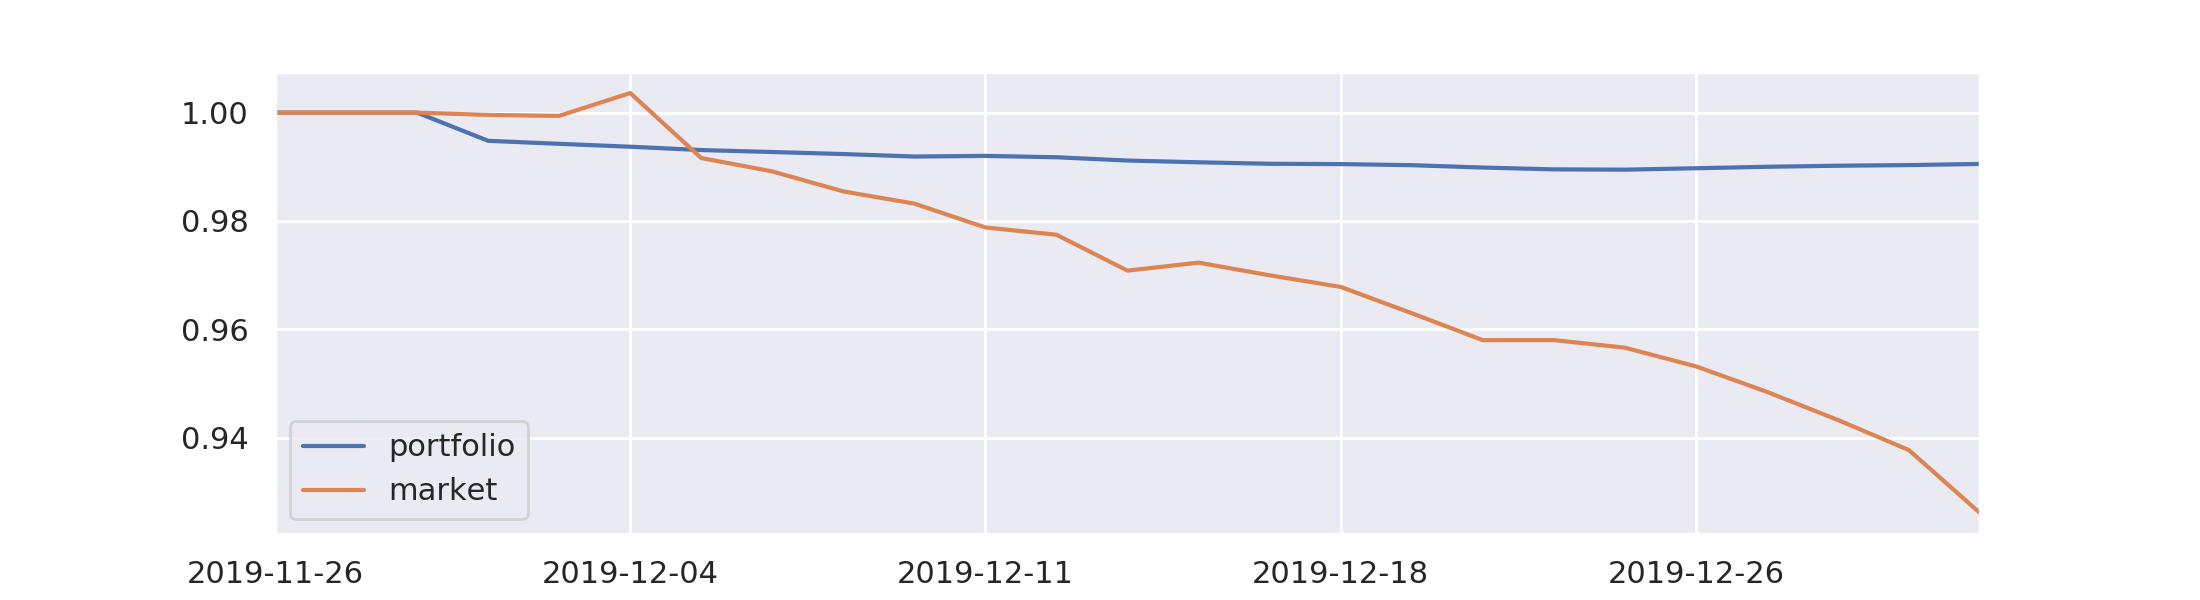

In [30]:
from IPython.display import Image
Image(filename='history.png') 

# References
- [Tennis Repo](https://github.com/daniel-fudge/sagemaker-tennis)
- [Amazon ECS](https://aws.amazon.com/ecs/)

#### SageMaker
- [SageMaker Example:  Extending PyTorch Container](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/advanced_functionality/pytorch_extending_our_containers)
- [How Amazon SageMaker interacts with your Docker container for training](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html)
- [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk)
- [scikit-bring-your-own](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb)
- [SageMaker PyTorch container](https://github.com/aws/sagemaker-pytorch-container)
- [SageMaker Instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/)
- [SageMaker Instance prices](https://aws.amazon.com/sagemaker/pricing/)

#### Docker
- [Dockerfile](https://docs.docker.com/engine/reference/builder/)
- [Docker home page](http://www.docker.com)
- [Getting started with Docker](https://docs.docker.com/get-started/)
- [Dockerfile reference](https://docs.docker.com/engine/reference/builder/)
- [docker run reference](https://docs.docker.com/engine/reference/run/)